# DATA 643: Recommender Systems
Final Project:  Book Crossing RecSys | Walt Wells, Summer 2017

# Notebook P4 - User Classification | Clustering

# Environment Prep

In [1]:
suppressMessages(library(Matrix))
suppressMessages(library(recommenderlab))
suppressMessages(library(ggplot2))
suppressMessages(library(cluster))
suppressMessages(library(data.table))
suppressMessages(library(factoextra))
source('helper.R')

# Data Import

In [2]:
binSVD <- readRDS("facBinMatrices.rds")
BinBook <- readRDS("binBookM.rds")

# CLARA to Classify Factorized Users

We will use an unsupervised learning technique to classify our factorized user matrix times the singular values, and then select the optimal number of user clusters.   

I initially explored using k-means and PAM (Partitioning Around Medoids), but the data set is large enough that it proved easier to use the CLARA algorithm (CLustering LARge Applications).   In addition, once we have determined the appropriate number of cluster, the CLARA algorithm can simply return IDs of the rows closest to each cluster's medioid, our ultimate goal in clustering.

## Review Factorized Matrix

In [3]:
str(binSVD)

List of 3
 $ s: num [1:16, 1:16] 43.7 0 0 0 0 ...
 $ u: num [1:33095, 1:16] 6.42e-07 8.14e-06 -4.66e-20 2.81e-20 3.59e-07 ...
 $ v: num [1:95795, 1:16] 2.93e-06 9.17e-09 2.47e-11 -3.96e-21 7.30e-07 ...


In [4]:
facUsers <- binSVD$u 
getSizeDim(facUsers)

[1] "Object facUsers size: 4.04 MB |  Dim: 33095 16"


## Determine k

We'll look for the bend in the elbow plot for the total within cluster sum of squares in order to determine the optimal number of clusters for CLarA to calculate.

In [5]:
k.max <- 50
data <- scale(facUsers)
wss <- sapply(1:k.max, 
        function(k){clara(data, k)$objective})

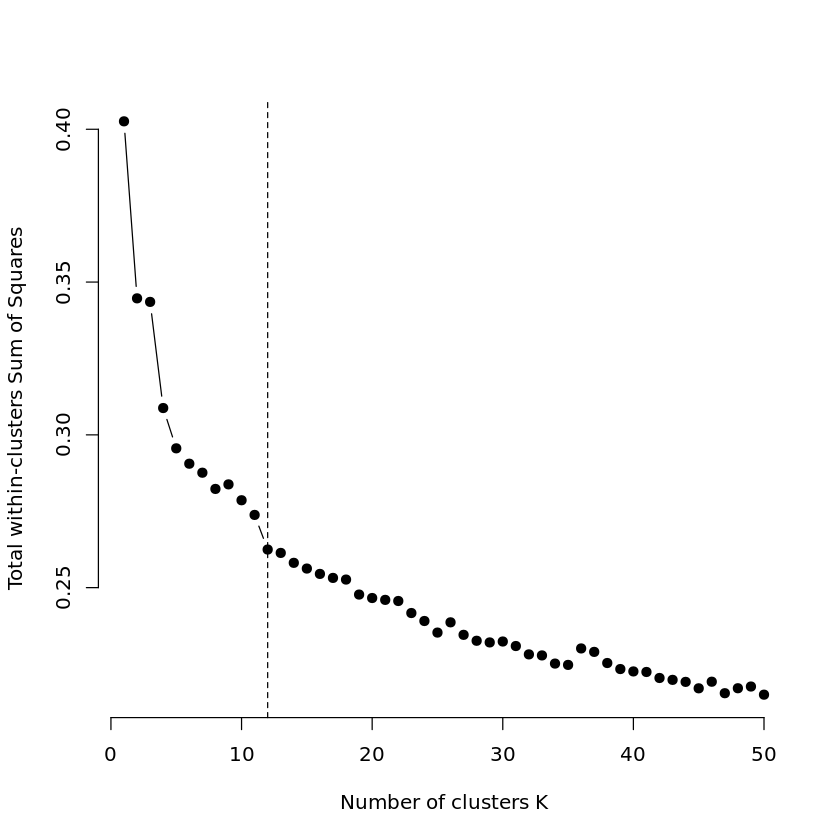

In [6]:
#http://www.sthda.com/english/wiki/print.php?id=239
plot(1:k.max, wss,
       type="b", pch = 19, frame = FALSE, 
       xlab="Number of clusters K",
       ylab="Total within-clusters Sum of Squares")
abline(v = 12, lty =2)

## Cluster Factorized Users

In [7]:
myCluster <- clara(scale(facUsers), 12)
nclusters <- nrow(myCluster$centers)

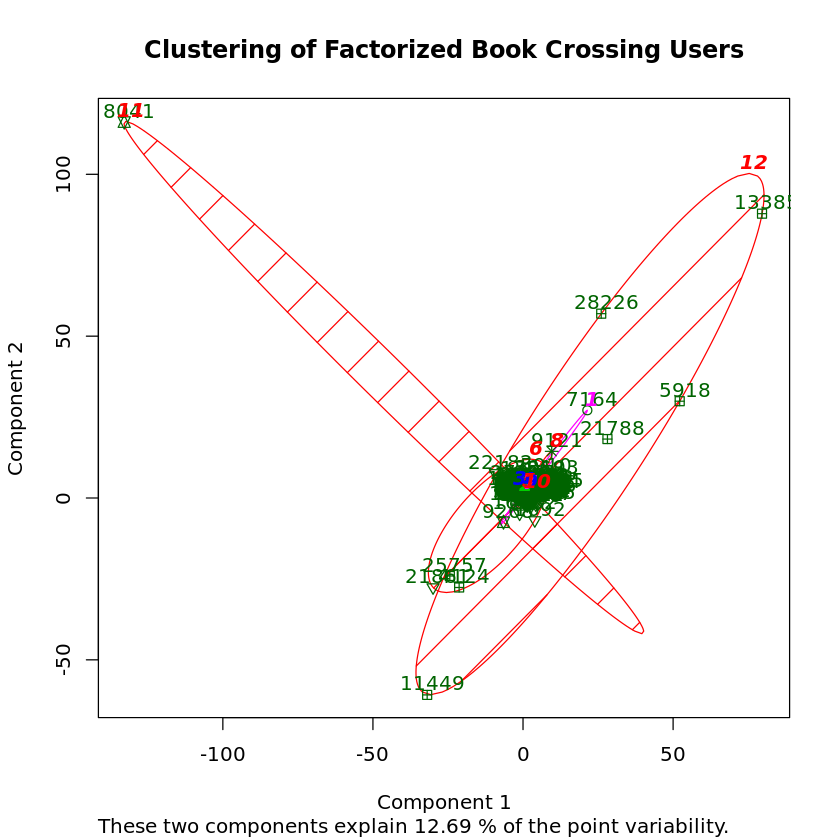

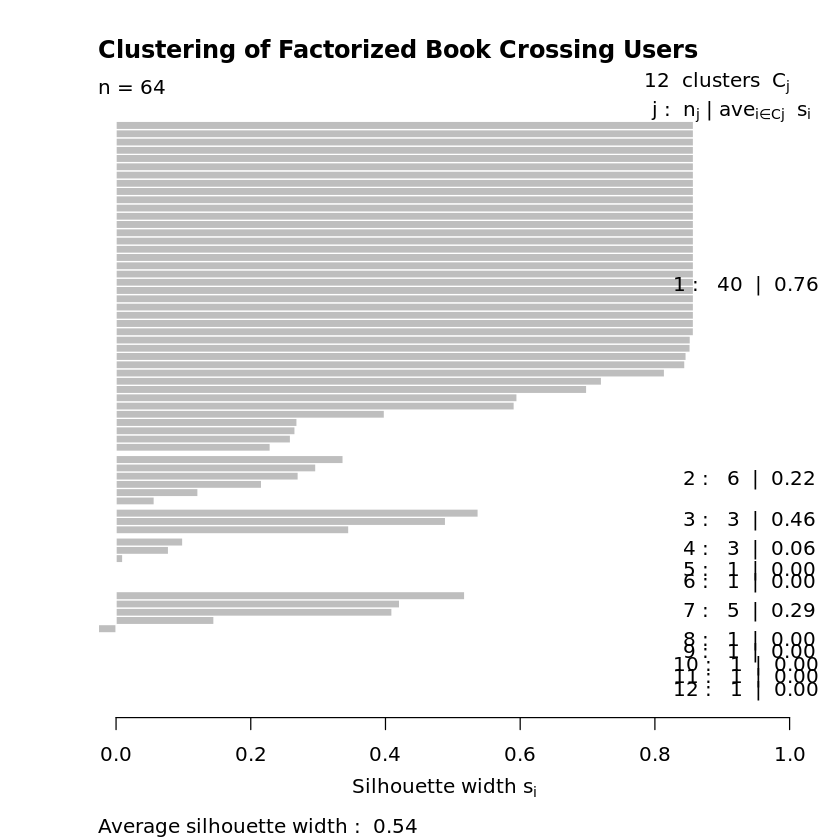

In [8]:
plot(myCluster, color=TRUE, shade=TRUE, labels=2, lines=0, main='Clustering of Factorized Book Crossing Users')

### Explore Outliers

So our clustering gives most users in the same cluster, with a few single entry outliers.   Let's explore a few of these outliers further.  

We'll first grab the binary ratings for the users associated with the outliers.   Since the data is too complex to visualize in full, we'll roughly get a sense of differences by simply getting a sum of the number of books each user responded to in every 1000 columns.

In [9]:
my1 <- as(BinBook[8041,], 'matrix')
my2 <- as(BinBook[13385,], 'matrix')
my3 <- as(BinBook[11449,], 'matrix')
my4 <- as(BinBook[01,], 'matrix') #main cluster, only rated one book - for comparison

In [10]:
m <- rbind(my1, my2, my3, my4)
m <- t(m)
m <- data.table(m)
getSizeDim(m)

[1] "Object m size: 1.463 MB |  Dim: 95795 4"


In [11]:
n <- nrow(m)
# using method at: https://stackoverflow.com/questions/28267398/summing-columns-on-every-nth-row-of-a-data-frame-in-r
outlierReview <- setDT(m)[, as.list(colSums(.SD)), by = gl(ceiling(n/1000), 1000, n)]
head(outlierReview)

gl,8041,13385,11449,1
1,2,1,9,1
2,13,4,16,0
3,4,13,2,0
4,2,11,11,0
5,12,4,12,0
6,2,2,3,0


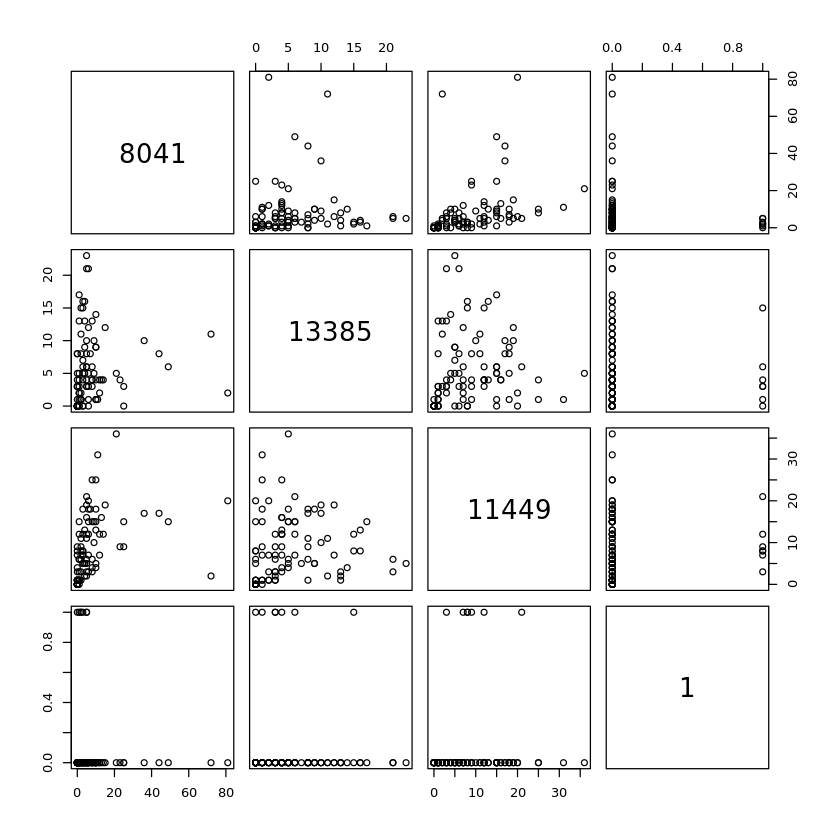

In [12]:
plot(outlierReview[,2:5])

Even just by looking at the sums of number of books rated per 1000, we can see some real differences in the preferences between these users.  The majority of our users only rated a book or two, as evidenced by the biggest cluster, represented by user 1.  We can see some pretty basic dissimilarity in our other clusters, too.   

If we were in production and continuously collecting data, hopefully our other clusters, population 1, would start to add more members. 

# Use Clusters To Find Users Closest to Cluster Centers

We will now take the rows our CLarA function declares as closest to the cluster center, and return two DFS: 
* A DF representing the binary rating for that row (to compare to a new user)
* A DF reprsenting the predicted ratings for that row (using our factorized matrix)

In [13]:
Index <- myCluster$i.med

### Helper:  Get Representative Cluster Rows

In [14]:
getRows <- function(ilist, source) {
    # given index of representative cluster rows and source to call, return DF of rows
    mylist <- list()
    for (i in ilist){
        dat <- as(source[i,], 'matrix')
        mylist[[i]] <- dat
    }
    final <- do.call(rbind, mylist)
}

In [21]:
isbn <- colnames(BinBook)
rows <- 1:length(Index)

In [22]:
binaryClus <- getRows(Index, BinBook) # binary cluster for comparison
colnames(binaryClus) <- isbn
rownames(binaryClus) <- rows
getSizeDim(binaryClus)

[1] "Object binaryClus size: 21.143 MB |  Dim: 12 95795"


In [23]:
UCluster <- getRows(Index, data.frame(binSVD$u))# U of predictive cluster for recommending
predClus <- UCluster %*% binSVD$s %*% t(binSVD$v) # reconstruct for prediction
colnames(predClus) <- isbn
rownames(predClus) <- rows
getSizeDim(predClus)

[1] "Object predClus size: 25.528 MB |  Dim: 12 95795"


In [24]:
export <- list(binary = binaryClus, 
               predicted = predClus)
saveRDS(export, 'clusteredPreds.rds')